# <font color=blue> __InferPloidy Application Example__  </font>
MLBI-lab@DKU, May 20, 2025

In [ ]:
## Required python packages
'''
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install scikit-network
'''
!pip install gdown
!pip install scanpy
!pip install infercnvpy
!pip install inferploidy 

In [4]:
## Import required packages
import copy, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from inferploidy import run_inferploidy, run_infercnv, plot_cnv, load_sample_data

warnings.filterwarnings('ignore')

### __Load data with celltype annotations__

In [5]:
data = 'BRCA' # 'BRCA', 'NSCLC', 'PDAC', 'CRC'
tissue = 'Breast' # 'Breast', 'Lung', 'Pancreas', 'Intestine'

adata = load_sample_data( data )
adata

Downloading...
From (original): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV
From (redirected): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV&confirm=t&uuid=6f9bd383-3cc9-4f9a-9161-2a0a9e6c79cd
To: /mnt/HDD2/Google_drive/PyPI_Git_Publish/pub_inferploidy/downloaded
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124M/124M [00:12<00:00, 9.95MB/s]


File saved to: BRCA.h5ad


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'

### __Run InferCNV and InferPloidy__

In [6]:
ref_key = 'celltype_major'
ref_cat = ['T cell', 'B cell', 'Myeloid cell', 'Fibroblast', 'Acinar cell']

run_infercnv(adata, ref_key = ref_key, ref_cat = ref_cat,
             gtf_file = None, species = 'hs',
             window_size = 100, n_cores = 4 )

  0%|          | 0/7 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cnv'
    obsm: 'X_cnv'

In [7]:
adata = run_inferploidy( adata, ref_key = ref_key, ref_cat = ref_cat,
                         N_runs = 7, n_cores = 4, verbose = True,
                         clustering_resolution = 6 )
adata

InferPloidy .. 
   1/7
   2/7
   3/7
   4/7
   5/7
   6/7
   7/7
InferPloidy .. done. (584) 


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset', 'cnv_ref_ind', 'iploidy_score', 'iploidy_dec', 'iploidy_init_group'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'cnv', 'inferploidy_summary'
    obsm: 'X_cnv', 'X_cnv_pca', 'inferploidy_results'

### __Check out CNV pattern__

... storing 'iploidy_dec' as categorical
... storing 'iploidy_init_group' as categorical
... storing 'deg_group' as categorical
... storing 'chr' as categorical


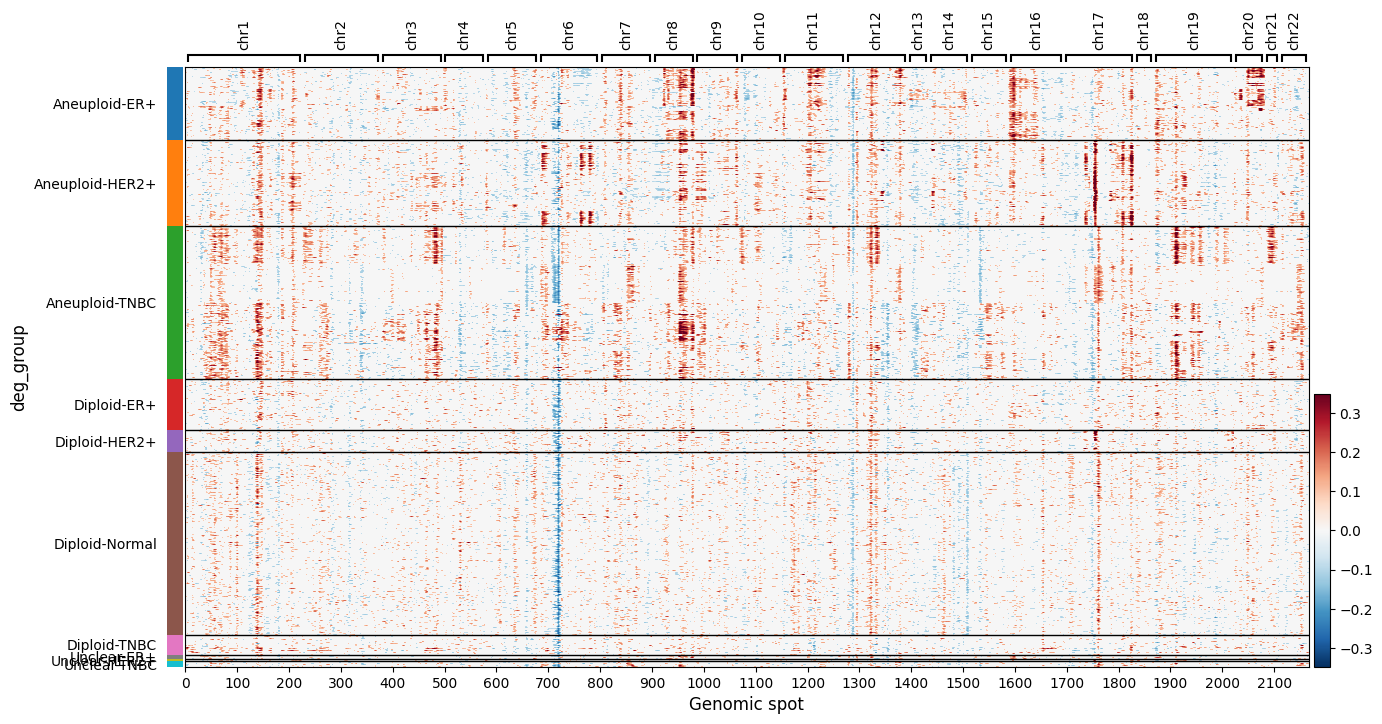

In [8]:
b = adata.obs['celltype_major'].isin(['Epithelial cell', 'Lung Epithelial cell', 'Ductal cell'])
adata_s = adata[b,:]

lst1 = list(adata_s.obs['iploidy_dec'])
lst2 = list(adata_s.obs['condition'])
deg_grouping = 'deg_group'
adata_s.obs[deg_grouping] = ['%s-%s' % (a1, a2) for a1, a2 in zip(lst1, lst2)]

## Select samples with the number of cells >= min.value
pcnt = adata_s.obs[deg_grouping].value_counts()
bp = pcnt >= 50
b = adata_s.obs[deg_grouping].isin(list(pcnt.index.values[bp]))
adata_s = adata_s[b,:]

## Plot CNV patterns of cell groups
axd = plot_cnv( adata_s, groupby = deg_grouping,
                title = '',
                title_fs = 15, title_y_pos = 1.11,
                label_fs = 12, tick_fs = 10,
                figsize = (15, 8), swap_axes = False,
                var_group_rotation = 90, cmap='RdBu_r', vmax = 1,
                cnv_obsm_key = 'X_cnv', cnv_uns_key = 'cnv')


### __CNV UMAP__

In [9]:
## Perform UMAP projection of CNV patterns
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep = 'X_cnv_pca', key_added = 'cnv_neighbors')
ad_tmp = sc.tl.umap(adata, neighbors_key = 'cnv_neighbors', copy = True)
adata.obsm['X_cnv_umap'] = ad_tmp.obsm['X_umap']

... storing 'iploidy_dec' as categorical
... storing 'iploidy_init_group' as categorical
... storing 'chromosome' as categorical
... storing 'gene_id' as categorical
... storing 'gene_name' as categorical


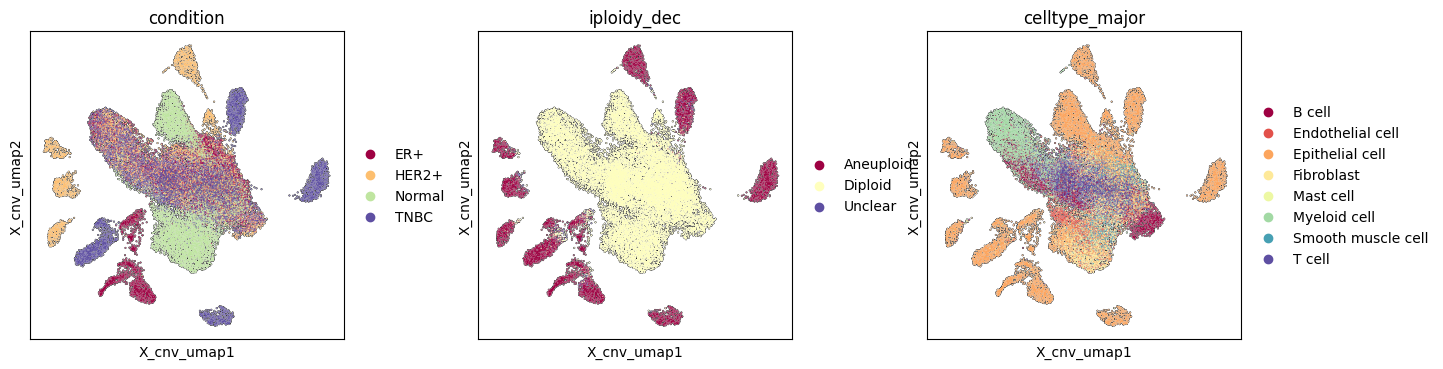

In [10]:
items_to_plot = ['condition', 'iploidy_dec', 'celltype_major']

plt.rcParams['figure.figsize'] = (4, 4)
fig = sc.pl.embedding( adata, basis = 'X_cnv_umap', neighbors_key = 'cnv_neighbors',
                       color=items_to_plot, wspace = 0.3, legend_fontsize = 10,
                       ncols = 3, palette = 'Spectral', return_fig = False,
                       add_outline = True, s = 3)